In [1]:
from nba_api.stats.endpoints import teamgamelogs,boxscoreadvancedv2,boxscorefourfactorsv2,boxscoremiscv2,boxscorescoringv2,boxscoretraditionalv2,boxscoreplayertrackv2
import pandas as pd
pd.set_option('display.max_columns', None)
from time import sleep

In [2]:
seasons = ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23']

In [2]:
# get all team game logs for all seasons
game_logs = []
for season in seasons:
    print(season)
    df = teamgamelogs.TeamGameLogs(season_nullable=season).get_data_frames()[0]
    df = df.sort_values(by='GAME_ID', ascending=True).reset_index(drop=True)
    game_logs.append(df)
    sleep(0.3)

2015-16
2016-17
2017-18
2018-19
2019-20
2020-21
2021-22
2022-23


In [3]:
game_logs = pd.concat(game_logs)
game_logs = game_logs.reset_index(drop=True)
game_logs['WL'] = game_logs['WL'].map({'W': 1, 'L': 0})
game_logs.to_csv('data/team_game_logs_2015_2022.csv', index=False)

In [2]:
game_logs = pd.read_csv('data/team_game_logs_2015_2022.csv')

In [3]:
game_ids = game_logs['GAME_ID'].unique()
game_ids = [f"00{game_id}" for game_id in game_ids]
print(game_ids)

['0021500001', '0021500002', '0021500003', '0021500004', '0021500005', '0021500006', '0021500007', '0021500008', '0021500009', '0021500010', '0021500011', '0021500012', '0021500013', '0021500014', '0021500015', '0021500016', '0021500017', '0021500018', '0021500019', '0021500020', '0021500021', '0021500022', '0021500023', '0021500024', '0021500025', '0021500026', '0021500027', '0021500028', '0021500029', '0021500030', '0021500031', '0021500032', '0021500033', '0021500034', '0021500035', '0021500036', '0021500037', '0021500038', '0021500039', '0021500040', '0021500041', '0021500042', '0021500043', '0021500044', '0021500045', '0021500046', '0021500047', '0021500048', '0021500049', '0021500050', '0021500051', '0021500052', '0021500053', '0021500054', '0021500055', '0021500056', '0021500057', '0021500058', '0021500059', '0021500060', '0021500061', '0021500062', '0021500063', '0021500064', '0021500065', '0021500066', '0021500067', '0021500068', '0021500069', '0021500070', '0021500071', '0021

In [6]:
boxscoreadvancedv2.BoxScoreAdvancedV2(game_id="0022000021").get_data_frames()[1]

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0022000021,1610612763,Grizzlies,MEM,Memphis,240.000000:00,104.9,106.7,113.3,116.2,-8.3,-9.5,0.541,2.00,14.7,0.241,0.691,0.46,9.367,9.5,0.468,0.530,1.0,0.200,107.24,105.0,87.5,105,0.439
1,0022000021,1610612737,Hawks,ATL,Atlanta,240.000000:00,113.3,116.2,104.9,106.7,8.3,9.5,0.605,1.53,16.0,0.309,0.759,0.54,13.925,14.3,0.500,0.577,1.0,0.197,107.24,105.0,87.5,105,0.561


In [4]:
# silence futurewarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [77]:
season_dict = {"00215":"2015-16", "00216":"2016-17", "00217":"2017-18", "00218":"2018-19", "00219":"2019-20", "00220":"2020-21", "00221":"2021-22", "00222":"2022-23"}

def merge_boxscores(boxscore_list):
    merged_bbx = pd.concat(boxscore_list, axis=1, join='outer')
    merged_bbx = merged_bbx.loc[:,~merged_bbx.columns.duplicated()]
    return merged_bbx
# Create dataframe for all boxscores
import os
if os.path.exists('data/team_boxscores_2015_2022.pkl'):
    boxscores_all = pd.read_pickle('data/team_boxscores_2015_2022.pkl')
    boxscores_all['GAME_ID'] = boxscores_all['GAME_ID'].astype(str)
    mask = boxscores_all['GAME_ID'].str.startswith('00')
    mask = mask.fillna(False)
    boxscores_all.loc[~mask, 'GAME_ID'] = [f"00{game_id}" for game_id in boxscores_all.loc[~mask, 'GAME_ID'].values.tolist()]
else:
    boxscores_all = pd.DataFrame()
boxscores_all_list = []
# For berbositiy of datadownload
num_all_game_ids = len(game_ids)
print(f'Total games to scrape: {num_all_game_ids}')
done_game_ids = len(boxscores_all['GAME_ID'].unique())
print(f'Already done games: {done_game_ids}')
# Loop through all game_ids
for game_id in game_ids:
    # Fix game_id
#    game_id = f"00{game_id}"
    # Check if the game_id is already in the dataframe
    if game_id in boxscores_all['GAME_ID'].values:
#        done_game_ids += 1
        continue
    # Download boxscore data
    # Collect them in a list
    boxscores = []
    try:
        # Traditional
        df = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id).get_data_frames()[1]
        boxscores.append(df)
        sleep(0.8)

        # Advanced
        df = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=game_id).get_data_frames()[1]
        boxscores.append(df)
        sleep(0.8)

        # Four Factors
        df = boxscorefourfactorsv2.BoxScoreFourFactorsV2(game_id=game_id).get_data_frames()[1]
        boxscores.append(df)
        sleep(0.8)

        # Misc
        df = boxscoremiscv2.BoxScoreMiscV2(game_id=game_id).get_data_frames()[1]
        boxscores.append(df)
        sleep(0.8)

        # Scoring
        df = boxscorescoringv2.BoxScoreScoringV2(game_id=game_id).get_data_frames()[1]
        boxscores.append(df)
        sleep(0.8)

        # Player Track
        df = boxscoreplayertrackv2.BoxScorePlayerTrackV2(game_id=game_id).get_data_frames()[1]
        boxscores.append(df)
        sleep(0.8)
    except:
        print(f"Error in game_id: {game_id}, saving the dataframes to csv")
        df = pd.DataFrame(boxscores_all_list,columns=boxscores_all.columns[:-1])
        df["SEASON"] = df["GAME_ID"].str[:5].map(season_dict)
        boxscores_all = pd.concat([boxscores_all,df]).drop_duplicates(subset=['GAME_ID','TEAM_ID'])
        boxscores_all = boxscores_all.drop_duplicates(subset=['GAME_ID','TEAM_ID'])
        boxscores_all = boxscores_all.reset_index(drop=True)
        boxscores_all.to_pickle('data/team_boxscores_2015_2022.pkl')
    # Merge all boxscores
    boxscore_merged = merge_boxscores(boxscores)

    # Add to the main list
    boxscores_all_list.extend(boxscore_merged.values)
#    boxscores_all = pd.concat([boxscores_all, boxscore_merged])

    # For verbosity of data download, print every ten percent done
    done_game_ids += 1
#    print(f'{done_game_ids} game_ids done out of {num_all_game_ids}')
#    if done_game_ids % (num_all_game_ids // 10) == 0:
#        print(f'{done_game_ids} game_ids done out of {num_all_game_ids}')
    # Sleep five seconds after every 100 games
    if done_game_ids % 100 == 0:
        print(f"Done with {done_game_ids} games")
        print('Sleeping for 30 seconds...')
        sleep(30)
#    break
boxscores_all = pd.concat([boxscores_all, pd.DataFrame(boxscores_all_list,columns=boxscores_all.columns)])
boxscores_all.head()

Total games to scrape: 9519
Already done games: 5940
Done with 6000 games
Sleeping for 30 seconds...
Done with 6100 games
Sleeping for 30 seconds...
Done with 6200 games
Sleeping for 30 seconds...
Done with 6300 games
Sleeping for 30 seconds...
Done with 6400 games
Sleeping for 30 seconds...
Done with 6500 games
Sleeping for 30 seconds...
Done with 6600 games
Sleeping for 30 seconds...
Done with 6700 games
Sleeping for 30 seconds...
Done with 6800 games
Sleeping for 30 seconds...
Done with 6900 games
Sleeping for 30 seconds...
Done with 7000 games
Sleeping for 30 seconds...
Done with 7100 games
Sleeping for 30 seconds...
Done with 7200 games
Sleeping for 30 seconds...
Done with 7300 games
Sleeping for 30 seconds...
Done with 7400 games
Sleeping for 30 seconds...
Error in game_id: 0022100400, saving the dataframes to csv
Done with 7500 games
Sleeping for 30 seconds...
Done with 7600 games
Sleeping for 30 seconds...
Done with 7700 games
Sleeping for 30 seconds...
Done with 7800 games
Sle

ValueError: 96 columns passed, passed data had 95 columns

In [58]:
boxscores_all.columns[:-1]

Index(['GAME_ID', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CITY',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
       'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
       'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TM_TOV_PCT',
       'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE',
       'PACE', 'PACE_PER40', 'POSS', 'PIE', 'FTA_RATE', 'OPP_EFG_PCT',
       'OPP_FTA_RATE', 'OPP_TOV_PCT', 'OPP_OREB_PCT', 'PTS_OFF_TOV',
       'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT', 'OPP_PTS_OFF_TOV',
       'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'BLKA', 'PFD',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'P

In [78]:
# drop the 42. element of all rows in boxscores_all_list
df = pd.DataFrame(boxscores_all_list,columns=boxscores_all.columns[:-1])
df["SEASON"] = df["GAME_ID"].str[:5].map(season_dict)
boxscores_all = pd.concat([boxscores_all, df])
boxscores_all.head()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLKA,PFD,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,SEASON
0,0021500001,1610612765,Pistons,DET,Detroit,240.000000:00,37,96,0.385,12,29,0.0,20,26,0.0,23,36,59,23,5,3,15,15,106,12.0,106.6,107.1,97.3,96.9,9.3,10.2,0.622,1.53,15.8,0.444,0.837,0.596,15.084,15.2,0.448,0.493,1.0,0.201,98.02,98.0,81.67,99.0,0.538,0.271,0.500,0.183,0.155,0.152,20.0,16.0,10.0,36.0,19.0,6.0,15.0,42.0,4,25,0.698,0.302,0.472,0.132,0.340,0.094,0.189,0.189,0.340,0.600,0.400,0.667,0.333,0.622,0.378,16.39,40.0,69.0,109.0,440.0,4.0,3.0,305.0,21.0,54.0,0.389,16.0,42.0,0.381,18.0,31.0,0.581,2015-16
1,0021500001,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,82,0.451,8,27,0.0,12,15,0.0,7,33,40,22,9,4,15,25,94,-12.0,97.3,96.9,106.6,107.1,-9.3,-10.2,0.595,1.47,17.5,0.163,0.556,0.404,15.528,15.5,0.500,0.530,1.0,0.201,98.02,98.0,81.67,97.0,0.462,0.183,0.448,0.271,0.151,0.444,19.0,6.0,15.0,42.0,20.0,16.0,10.0,36.0,3,15,0.671,0.329,0.617,0.170,0.255,0.160,0.128,0.202,0.447,0.483,0.517,1.000,0.000,0.595,0.405,16.67,26.0,72.0,93.0,430.0,2.0,0.0,319.0,15.0,33.0,0.455,22.0,49.0,0.449,13.0,26.0,0.500,2015-16
2,0021500002,1610612739,Cavaliers,CLE,Cleveland,240.000000:00,38,94,0.404,9,29,0.0,10,17,0.0,11,39,50,26,5,7,10,21,95,-2.0,93.6,96.9,94.1,99.0,-0.5,-2.0,0.684,2.36,18.8,0.276,0.759,0.509,10.840,11.2,0.452,0.468,1.0,0.199,102.30,98.0,81.67,98.0,0.521,0.181,0.466,0.264,0.126,0.241,15.0,12.0,13.0,42.0,13.0,13.0,15.0,32.0,10,22,0.691,0.309,0.611,0.168,0.284,0.137,0.105,0.158,0.442,0.621,0.379,0.889,0.111,0.684,0.316,17.51,38.0,78.0,114.0,425.0,9.0,3.0,304.0,17.0,42.0,0.405,21.0,52.0,0.404,6.0,13.0,0.462,2015-16
3,0021500002,1610612741,Bulls,CHI,Chicago,240.000000:00,37,87,0.425,7,19,0.0,16,23,0.0,7,40,47,13,6,10,13,22,97,2.0,94.1,99.0,93.6,96.9,0.5,2.0,0.351,1.00,10.6,0.241,0.724,0.491,12.607,13.3,0.466,0.499,1.0,0.198,102.30,98.0,81.67,98.0,0.479,0.264,0.452,0.181,0.108,0.276,13.0,13.0,15.0,32.0,15.0,12.0,13.0,42.0,7,21,0.782,0.218,0.619,0.289,0.216,0.155,0.165,0.134,0.330,0.233,0.767,0.857,0.143,0.351,0.649,17.45,29.0,71.0,96.0,399.0,1.0,1.0,281.0,19.0,41.0,0.463,18.0,46.0,0.391,16.0,29.0,0.552,2015-16
4,0021500003,1610612740,Pelicans,NOP,New Orleans,240.000000:00,35,83,0.422,6,18,0.0,19,27,0.0,8,25,33,21,9,3,18,26,95,-16.0,89.7,93.1,106.0,107.8,-16.3,-14.6,0.600,1.11,15.6,0.255,0.554,0.411,17.945,18.6,0.458,0.501,1.0,0.198,105.28,102.5,85.42,102.0,0.375,0.325,0.474,0.229,0.191,0.446,29.0,8.0,18.0,40.0,26.0,21.0,13.0,54.0,7,29,0.783,0.217,0.611,0.189,0.189,0.189,0.200,0.305,0.421,0.586,0.414,0.667,0.333,0.600,0.400,17.59,31.0,74.0,104.0,406.0,4.0,1.0,285.0,14.0,35.0,0.400,21.0,48.0,0.438,21.0,37.0,0.568,2015-16


In [35]:
# drop where gameid does NOT start with 00
mask = boxscores_all['GAME_ID'].str.startswith('00')
mask = mask.fillna(False)
boxscores_all = boxscores_all[mask]
boxscores_all.shape

(62, 95)

In [45]:
boxscores_all.columns.to_list().index("E_USG_PCT")

42

In [79]:
boxscores_all.tail()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLKA,PFD,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,SEASON
7153,0022201228,1610612747,Lakers,LAL,Los Angeles,240.000000:00,47,97,0.485,18,45,0.400,16,21,0.762,10,39,49,28,4,7,10,9,128,11.0,119.4,121.9,108.7,110.4,10.7,11.5,0.596,2.55,19.3,0.250,0.804,0.524,10.257,10.5,0.577,0.602,1.0,0.198,107.44,105.5,87.92,105.0,0.530,0.216,0.554,0.059,0.102,0.196,13.0,22.0,26.0,50.0,7.0,13.0,14.0,76.0,4,16,0.536,0.464,0.453,0.063,0.422,0.203,0.125,0.102,0.391,0.586,0.414,0.611,0.389,0.596,0.404,17.16,19.0,56.0,74.0,408.0,3.0,4.0,285.0,14.0,27.0,0.519,33.0,69.0,0.478,27.0,37.0,0.730,2022-23
7154,0022201229,1610612756,Suns,PHX,Phoenix,240.000000:00,42,99,0.424,14,37,0.378,16,22,0.727,12,35,47,29,4,3,7,21,114,-5.0,110.0,110.7,111.7,116.7,-1.7,-6.0,0.690,4.14,20.0,0.271,0.679,0.470,6.752,6.8,0.495,0.524,1.0,0.201,105.12,102.5,85.42,103.0,0.483,0.222,0.515,0.240,0.094,0.321,12.0,15.0,11.0,50.0,10.0,17.0,13.0,68.0,5,18,0.626,0.374,0.491,0.053,0.368,0.096,0.140,0.105,0.439,0.536,0.464,1.000,0.000,0.690,0.310,17.44,31.0,60.0,89.0,360.0,2.0,1.0,230.0,25.0,50.0,0.500,24.0,50.0,0.480,20.0,34.0,0.588,2022-23
7155,0022201229,1610612746,Clippers,LAC,LA,240.000000:00,49,100,0.490,5,23,0.217,16,24,0.667,14,39,53,22,3,5,10,18,119,5.0,111.7,116.7,110.0,110.7,1.7,6.0,0.449,2.20,15.4,0.321,0.729,0.530,9.384,9.8,0.515,0.538,1.0,0.197,105.12,102.5,85.42,102.0,0.517,0.240,0.495,0.222,0.068,0.271,10.0,17.0,13.0,68.0,12.0,15.0,11.0,50.0,3,21,0.770,0.230,0.739,0.168,0.126,0.109,0.134,0.084,0.571,0.409,0.591,0.800,0.200,0.449,0.551,18.09,35.0,52.0,83.0,420.0,2.0,1.0,296.0,15.0,34.0,0.441,27.0,65.0,0.415,21.0,35.0,0.600,2022-23
7156,0022201230,1610612757,Trail Blazers,POR,Portland,240.000000:00,38,95,0.400,9,35,0.257,16,24,0.667,6,24,30,25,5,3,14,9,101,-56.0,88.9,90.2,142.7,141.4,-53.7,-51.3,0.658,1.79,17.3,0.180,0.763,0.404,12.328,12.5,0.447,0.478,1.0,0.201,111.80,111.5,92.92,112.0,0.264,0.253,0.745,0.167,0.145,0.237,17.0,14.0,14.0,48.0,25.0,9.0,26.0,60.0,6,18,0.632,0.368,0.574,0.099,0.267,0.139,0.158,0.168,0.475,0.586,0.414,0.889,0.111,0.658,0.342,18.08,23.0,70.0,89.0,481.0,8.0,1.0,357.0,19.0,29.0,0.655,39.0,67.0,0.582,20.0,28.0,0.714,2022-23
7157,0022201230,1610612744,Warriors,GSW,Golden State,240.000000:00,58,96,0.604,27,49,0.551,14,16,0.875,9,49,58,47,13,6,15,18,157,56.0,142.7,141.4,88.9,90.2,53.7,51.3,0.810,2.94,28.3,0.237,0.820,0.596,14.540,14.4,0.745,0.762,1.0,0.198,111.80,111.5,92.92,111.0,0.736,0.167,0.447,0.253,0.123,0.180,25.0,9.0,26.0,60.0,17.0,14.0,14.0,48.0,3,9,0.490,0.510,0.395,0.013,0.516,0.166,0.089,0.159,0.382,0.774,0.226,0.852,0.148,0.810,0.190,18.26,16.0,48.0,64.0,393.0,4.0,1.0,268.0,16.0,41.0,0.390,22.0,54.0,0.407,24.0,33.0,0.727,2022-23


In [82]:
boxscores_all = boxscores_all.drop_duplicates(subset=["GAME_ID","TEAM_ID"],keep='first')


In [80]:
boxscores_all.shape

(22074, 96)

In [20]:
boxscores_all[(boxscores_all['FGM'] == 37) & (boxscores_all['TEAM_ID'] == 1610612737)]

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLKA,PFD,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT
0,0021500001,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,9,4,15,25,94,-12.0,97.3,96.9,106.6,107.1,-9.3,-10.2,0.595,1.47,17.5,NaN,0.556,NaN,15.528,15.5,0.500,0.530,1.0,0.201,98.02,98.00,81.67,97,0.462,0.183,0.448,0.271,0.151,0.444,19.0,6.0,15.0,42.0,20.0,16.0,10.0,36.0,3,15,0.671,0.329,0.617,0.170,0.255,0.160,0.128,0.202,0.447,0.483,0.517,1.000,0.000,0.595,0.405,16.67,26,72,93,430,2,0,319,15,33,0.455,22,49,0.449,13,26,0.500
76,0021500039,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,88,0.420,7,29,0.241,13,14,0.929,9,39,48,22,9,6,11,16,94,2.0,97.8,98.9,96.2,95.8,1.5,3.1,0.595,2.00,17.3,0.231,0.778,0.509,11.439,11.6,0.460,0.499,1.0,0.202,95.88,95.50,79.58,95,0.501,0.159,0.453,0.174,0.126,0.222,15.0,10.0,12.0,44.0,12.0,11.0,13.0,30.0,13,14,0.670,0.330,0.638,0.170,0.223,0.128,0.138,0.160,0.468,0.533,0.467,0.857,0.143,0.595,0.405,17.30,35,77,112,433,4,0,320,18,40,0.450,19,48,0.396,10,19,0.526
108,0021500055,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,90,0.411,7,21,0.333,17,22,0.773,16,35,51,25,10,1,15,14,98,6.0,98.3,100.0,92.9,94.8,5.4,5.2,0.676,1.56,17.8,0.339,NaN,NaN,16.051,16.3,0.450,0.492,1.0,0.195,99.36,97.50,81.25,98,0.562,0.244,0.471,0.186,0.192,0.314,22.0,17.0,11.0,52.0,14.0,20.0,12.0,52.0,9,21,0.767,0.233,0.612,0.082,0.214,0.112,0.173,0.224,0.531,0.600,0.400,1.000,0.000,0.676,0.324,16.87,35,59,91,469,7,2,345,21,50,0.420,16,40,0.400,20,31,0.645
122,0021500062,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,76,0.487,8,22,0.364,19,24,0.792,6,28,34,27,15,10,13,17,101,14.0,105.7,108.6,92.8,92.6,12.9,16.0,0.730,1.80,21.0,0.268,0.638,0.466,15.697,16.1,0.539,0.583,1.0,0.199,94.64,93.50,77.92,93,0.595,0.316,0.464,0.157,0.203,0.362,25.0,5.0,16.0,34.0,16.0,10.0,11.0,38.0,4,19,0.711,0.289,0.574,0.238,0.238,0.158,0.188,0.248,0.337,0.655,0.345,1.000,0.000,0.730,0.270,16.74,24,56,78,454,6,1,339,14,29,0.483,23,47,0.489,12,18,0.667
294,0021500148,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,76,0.487,8,22,0.364,14,17,0.824,8,25,33,26,9,5,15,16,96,-1.0,106.1,105.5,103.8,106.6,2.3,-1.1,0.703,1.73,20.9,0.256,0.667,0.451,16.578,16.5,0.539,0.575,1.0,0.201,91.98,91.00,75.83,91,0.509,0.224,0.559,0.224,0.214,0.333,17.0,9.0,13.0,38.0,16.0,11.0,9.0,42.0,7,15,0.711,0.289,0.604,0.208,0.250,0.135,0.146,0.177,0.396,0.655,0.345,0.875,0.125,0.703,0.297,16.89,28,53,77,383,3,2,279,14,28,0.500,23,48,0.479,13,19,0.684
482,0021500242,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,87,0.425,6,26,0.231,8,13,0.615,12,31,43,28,9,5,18,17,88,-20.0,89.1,91.7,110.4,111.3,-21.3,-19.7,0.757,1.56,20.2,0.283,0.711,0.480,18.233,18.8,0.460,0.475,1.0,0.199,98.26,96.50,80.42,96,0.392,0.149,0.524,0.235,0.164,0.289,21.0,11.0,18.0,40.0,19.0,5.0,14.0,40.0,9,14,0.701,0.299,0.705,0.250,0.205,0.205,0.091,0.239,0.455,0.710,0.290,1.000,0.000,0.757,0.243,17.10,30,60,89,423,1,1,308,15,32,0.469,22,55,0.400,8,13,0.615
16,0021500286,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,74,0.500,10,26,0.385,16,20,0.800,9,34,43,24,11,9,17,11,100,13.0,110.1,108.7,93.8,94.6,16.3,14.1,0.649,1.41,19.4,0.256,0.667,0.495,18.722,18.5,0.568,0.604,1.0,0.200,91.76,92.00,76.67,92,0.619,0.270,0.448,0.151,0.173,0.333,20.0,9.0,13.0,40.0,20.0,14.0,8.0,30.0,7,14,0.64

In [81]:
boxscores_all['GAME_ID'].value_counts()

GAME_ID
0022100082    4
0022000582    4
0022000574    4
0022000575    4
0022000576    4
             ..
0021700714    2
0021700715    2
0021700716    2
0021700717    2
0022201230    2
Name: count, Length: 9519, dtype: int64

In [14]:
len("0021500001")

10

In [84]:
boxscores_all = boxscores_all.sort_values(by='GAME_ID', ascending=True)
boxscores_all = boxscores_all.reset_index(drop=True)

In [23]:
mask = boxscores_all['GAME_ID'].str.len() == 10
boxscores_all = boxscores_all[mask]

In [83]:
done_game_ids = len(boxscores_all['GAME_ID'].unique())
print(f'Done with {done_game_ids} games')

Done with 9519 games


In [85]:
boxscores_all.to_csv('data/team_boxscores_2015_2022.csv', index=False)


In [31]:
boxscores_all.dtypes

GAME_ID               object
TEAM_ID              float64
TEAM_NAME             object
TEAM_ABBREVIATION     object
TEAM_CITY             object
                      ...   
UFGA                 float64
UFG_PCT              float64
DFGM                 float64
DFGA                 float64
DFG_PCT              float64
Length: 95, dtype: object

In [86]:
boxscores_all[int_cols].isna().sum()

TEAM_ID               0
FGM                   0
FGA                   0
FG3M                  0
FG3A                  0
FG3_PCT               0
FTM                   0
FTA                   0
FT_PCT                0
OREB                  0
DREB                  0
REB                   0
AST                   0
STL                   0
BLK                   0
TO                    0
PF                    0
PTS                   0
PLUS_MINUS            0
PTS_OFF_TOV           0
PTS_2ND_CHANCE        0
PTS_FB                0
PTS_PAINT             0
OPP_PTS_OFF_TOV       0
OPP_PTS_2ND_CHANCE    0
OPP_PTS_FB            0
OPP_PTS_PAINT         0
BLKA                  0
PFD                   0
ORBC                  2
DRBC                  2
RBC                   2
TCHS                  2
SAST                  2
FTAST                 2
PASS                  2
CFGM                  2
CFGA                  2
UFGM                  2
UFGA                  2
DFGM                  2
DFGA            

In [87]:
def fill_na_oreb_pct(row):
    if pd.isna(row["OREB_PCT"]):
        game_id = row["GAME_ID"]
        # Get other teams boxscore
        other_team = boxscores_all[(boxscores_all["GAME_ID"] == game_id) & (boxscores_all["TEAM_ID"] != row["TEAM_ID"])]
        row["OREB_PCT"] = round(row["OREB"] /  (row["OREB"] + other_team["DREB"].values[0]), 3)        
    return row
def fill_na_dreb_pct(row):
    if pd.isna(row["DREB_PCT"]):
        game_id = row["GAME_ID"]
        # Get other teams boxscore
        other_team = boxscores_all[(boxscores_all["GAME_ID"] == game_id) & (boxscores_all["TEAM_ID"] != row["TEAM_ID"])]
        row["DREB_PCT"] = round(row["DREB"] / (row["DREB"] + other_team["OREB"].values[0]), 3)
    return row
def fill_na_reb_pct(row):
    if pd.isna(row["REB_PCT"]):
        team_rebounds = row["REB"]
        game_id = row["GAME_ID"]
        # Get other teams boxscore
        other_team = boxscores_all[(boxscores_all["GAME_ID"] == game_id) & (boxscores_all["TEAM_ID"] != row["TEAM_ID"])]
        other_team_rebounds = other_team["REB"].values[0]
        total_rebounds = team_rebounds + other_team_rebounds
        row["REB_PCT"] = round(team_rebounds / total_rebounds,3)
    return row

boxscores_all = boxscores_all.apply(fill_na_oreb_pct, axis=1)
boxscores_all = boxscores_all.apply(fill_na_dreb_pct, axis=1)
boxscores_all = boxscores_all.apply(fill_na_reb_pct, axis=1)

In [89]:
# Other statistics cant be calculated if they are missing --> mean imputation
# Get the columns that have missing values
missing_values = boxscores_all.columns[boxscores_all.isna().any()].tolist()
print(f"Columns with missing values: {missing_values}")

# Fill missing values with the mean of the team in given season
def fill_na_mean(row):
    for column in missing_values:
        if pd.isna(row[column]):
            team_id = row["TEAM_ID"]
            season = row["SEASON"]
            team_mean = boxscores_all[(boxscores_all["TEAM_ID"] == team_id) & (boxscores_all["SEASON"] == season)][column].mean()
            row[column] = team_mean
    return row

# Add season column to team_boxscores
# Create a dictionary to map the GAME_ID's first three digits to the season
season_dict = {"00215":"2015-16", "00216":"2016-17", "00217":"2017-18", "00218":"2018-19", "00219":"2019-20", "00220":"2020-21", "00221":"2021-22", "00222":"2022-23"}
# Map the first three digits of GAME_ID to the season
boxscores_all["SEASON"] = boxscores_all["GAME_ID"].apply(lambda x: season_dict[str(x)[:5]])
boxscores_all.head()

boxscores_all = boxscores_all.apply(fill_na_mean, axis=1)

Columns with missing values: ['PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 'CFGM', 'CFGA', 'CFG_PCT', 'UFGM', 'UFGA', 'UFG_PCT', 'DFGM', 'DFGA', 'DFG_PCT']


In [90]:
int_cols = ['TEAM_ID','FGM','FGA','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS',
            'PTS_OFF_TOV','PTS_2ND_CHANCE','PTS_FB','PTS_PAINT','OPP_PTS_OFF_TOV','OPP_PTS_2ND_CHANCE','OPP_PTS_FB','OPP_PTS_PAINT','BLKA','PFD',
            'ORBC','DRBC','RBC','TCHS','SAST','FTAST','PASS','CFGM','CFGA','UFGM','UFGA','DFGM','DFGA']
boxscores_all[int_cols] = boxscores_all[int_cols].astype(int)
boxscores_all.to_pickle('data/team_boxscores_2015_2022.pkl')

In [91]:
temp = pd.read_pickle('data/team_boxscores_2015_2022.pkl')
temp.head()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,OPP_PTS_OFF_TOV,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,BLKA,PFD,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,SEASON
0,0021500001,1610612765,Pistons,DET,Detroit,240.000000:00,37,96,0.385,12,29,0,20,26,0,23,36,59,23,5,3,15,15,106,12,106.6,107.1,97.3,96.9,9.3,10.2,0.622,1.53,15.8,0.444,0.837,0.596,15.084,15.2,0.448,0.493,1.0,0.201,98.02,98.0,81.67,99.0,0.538,0.271,0.500,0.183,0.155,0.152,20,16,10,36,19,6,15,42,4,25,0.698,0.302,0.472,0.132,0.340,0.094,0.189,0.189,0.340,0.600,0.400,0.667,0.333,0.622,0.378,16.39,40,69,109,440,4,3,305,21,54,0.389,16,42,0.381,18,31,0.581,2015-16
1,0021500001,1610612737,Hawks,ATL,Atlanta,240.000000:00,37,82,0.451,8,27,0,12,15,0,7,33,40,22,9,4,15,25,94,-12,97.3,96.9,106.6,107.1,-9.3,-10.2,0.595,1.47,17.5,0.163,0.556,0.404,15.528,15.5,0.500,0.530,1.0,0.201,98.02,98.0,81.67,97.0,0.462,0.183,0.448,0.271,0.151,0.444,19,6,15,42,20,16,10,36,3,15,0.671,0.329,0.617,0.170,0.255,0.160,0.128,0.202,0.447,0.483,0.517,1.000,0.000,0.595,0.405,16.67,26,72,93,430,2,0,319,15,33,0.455,22,49,0.449,13,26,0.500,2015-16
2,0021500002,1610612739,Cavaliers,CLE,Cleveland,240.000000:00,38,94,0.404,9,29,0,10,17,0,11,39,50,26,5,7,10,21,95,-2,93.6,96.9,94.1,99.0,-0.5,-2.0,0.684,2.36,18.8,0.276,0.759,0.509,10.840,11.2,0.452,0.468,1.0,0.199,102.30,98.0,81.67,98.0,0.521,0.181,0.466,0.264,0.126,0.241,15,12,13,42,13,13,15,32,10,22,0.691,0.309,0.611,0.168,0.284,0.137,0.105,0.158,0.442,0.621,0.379,0.889,0.111,0.684,0.316,17.51,38,78,114,425,9,3,304,17,42,0.405,21,52,0.404,6,13,0.462,2015-16
3,0021500002,1610612741,Bulls,CHI,Chicago,240.000000:00,37,87,0.425,7,19,0,16,23,0,7,40,47,13,6,10,13,22,97,2,94.1,99.0,93.6,96.9,0.5,2.0,0.351,1.00,10.6,0.241,0.724,0.491,12.607,13.3,0.466,0.499,1.0,0.198,102.30,98.0,81.67,98.0,0.479,0.264,0.452,0.181,0.108,0.276,13,13,15,32,15,12,13,42,7,21,0.782,0.218,0.619,0.289,0.216,0.155,0.165,0.134,0.330,0.233,0.767,0.857,0.143,0.351,0.649,17.45,29,71,96,399,1,1,281,19,41,0.463,18,46,0.391,16,29,0.552,2015-16
4,0021500003,1610612740,Pelicans,NOP,New Orleans,240.000000:00,35,83,0.422,6,18,0,19,27,0,8,25,33,21,9,3,18,26,95,-16,89.7,93.1,106.0,107.8,-16.3,-14.6,0.600,1.11,15.6,0.255,0.554,0.411,17.945,18.6,0.458,0.501,1.0,0.198,105.28,102.5,85.42,102.0,0.375,0.325,0.474,0.229,0.191,0.446,29,8,18,40,26,21,13,54,7,29,0.783,0.217,0.611,0.189,0.189,0.189,0.200,0.305,0.421,0.586,0.414,0.667,0.333,0.600,0.400,17.59,31,74,104,406,4,1,285,14,35,0.400,21,48,0.438,21,37,0.568,2015-16


In [26]:
boxscores_all.isna().sum()

GAME_ID              0
TEAM_ID              0
TEAM_NAME            0
TEAM_ABBREVIATION    0
TEAM_CITY            0
                    ..
UFGA                 4
UFG_PCT              4
DFGM                 4
DFGA                 4
DFG_PCT              4
Length: 95, dtype: int64

In [32]:
game_logs[game_logs['AVAILABLE_FLAG'].isna()]


,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
550,2015-16,1610612746,LAC,LA Clippers,0021500276,2015-12-02T00:00:00,LAC vs. IND,L,48.0,30,79,0.380,6,27,0.222,25,39,0.641,10,30,40,19,15.0,4,2,6,31,26,91,-12.0,1,1231,1231,1231,155,2327,1874,2236,1739,728,2217,255,62,2141,1134,1687,1699,1736,1303,2146,2051,1520,2419,204,2030,1970,NaN
551,2015-16,1610612754,IND,Indiana Pacers,0021500276,2015-12-02T00:00:00,IND @ LAC,W,48.0,32,76,0.421,7,20,0.350,32,39,0.821,9,38,47,16,15.0,7,6,2,26,31,103,12.0,1,1,1,1,155,2154,2158,1754,1415,1678,1198,31,62,729,1379,417,693,2162,1303,1275,636,169,2173,30,1135,434,NaN
4968,2017-18,1610612744,GSW,Golden State Warriors,0021700025,2017-10-20T00:00:00,GSW @ NOP,W,48.0,47,91,0.516,18,40,0.450,16,20,0.800,10,39,49,29,18.0,6,8,4,23,19,128,8.0,1,1,1,1,123,157,519,389,43,113,392,1151,1320,928,965,355,427,298,1987,1579,195,791,1836,1272,83,648,NaN
4969,2017-18,1610612740,NOP,New Orleans Pelicans,0021700025,2017-10-20T00:00:00,NOP vs. GSW,L,48.0,45,98,0.459,16,36,0.444,14,22,0.636,16,34,50,26,19.0,8,4,8,19,23,120,-8.0,1,1231,1231,1231,123,315,99,1255,151,294,412,1509,1040,2201,114,1070,345,636,2139,918,1251,2130,934,453,307,1745,NaN


Data is still present for the rows above, therefore they shall be kept for analysis

In [37]:
game_logs['AVAILABLE_FLAG'].value_counts()

AVAILABLE_FLAG
1.0    18782
2.0      252
Name: count, dtype: int64

In [38]:
game_logs[game_logs['AVAILABLE_FLAG'] == 2.0]

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
478,2015-16,1610612751,BKN,Brooklyn Nets,0021500240,2015-11-28T00:00:00,BKN @ CLE,L,48.0,33,81,0.407,4,17,0.235,18,24,0.750,8,38,46,21,16.0,9,4,11,18,19,88,-2.0,1,1231,1231,1231,155,2038,1621,1952,2200,2063,2150,1016,1013,1335,1618,417,833,1358,1535,671,1269,2393,664,1344,2186,1264,2.0
479,2015-16,1610612739,CLE,Cleveland Cavaliers,0021500240,2015-11-28T00:00:00,CLE vs. BKN,W,48.0,35,87,0.402,9,27,0.333,11,17,0.647,12,37,49,20,20.0,9,11,4,19,18,90,2.0,1,1,1,1,155,1756,808,2016,861,728,1305,2093,1899,2101,692,531,451,1558,2198,671,38,749,868,1594,2103,1138,2.0
558,2015-16,1610612759,SAS,San Antonio Spurs,0021500280,2015-12-03T00:00:00,SAS @ MEM,W,48.0,40,80,0.500,10,18,0.556,13,18,0.722,10,38,48,27,15.0,8,8,6,21,17,103,20.0,1,1,1,1,155,775,1751,449,634,1958,63,1842,1787,1605,1134,417,575,349,1303,953,231,1520,1352,1798,1135,145,2.0
559,2015-16,1610612763,MEM,Memphis Grizzlies,0021500280,2015-12-03T00:00:00,MEM vs. SAS,L,48.0,30,80,0.375,2,16,0.125,21,25,0.840,9,28,37,19,11.0,6,6,8,17,21,83,-20.0,1,1231,1231,1231,155,2327,1751,2272,2423,2153,2441,615,886,562,1379,2003,2042,1736,419,1605,636,2077,482,902,2348,2286,2.0
2472,2016-17,1610612761,TOR,Toronto Raptors,0021600007,2016-10-26T00:00:00,TOR vs. DET,W,48.0,41,86,0.477,3,18,0.167,24,29,0.828,14,37,51,17,12.0,8,0,0,22,24,109,18.0,1,1,1,1,141,745,1041,875,2404,2258,2402,342,457,712,307,533,263,2076,668,886,2422,1,1622,337,902,217,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,2019-20,1610612758,SAC,Sacramento Kings,0021900064,2019-10-30T00:00:00,SAC vs. CHA,L,48.0,44,96,0.458,14,46,0.304,9,12,0.750,10,29,39,26,15.0,11,5,3,19,17,111,-7.0,1,1060,1060,1060,139,496,267,1090,562,98,1543,1949,1973,1227,918,1763,1661,688,1078,212,785,354,651,1627,1057,1406,2.0
9968,2019-20,1610612744,GSW,Golden State Warriors,0021900065,2019-10-30T00:00:00,GSW vs. PHX,L,48.0,36,82,0.439,8,28,0.286,30,36,0.833,7,36,43,24,18.0,8,6,4,22,22,110,-11.0,1,1060,1060,1060,139,1710,1762,1359,1773,1661,1684,64,84,549,1604,749,1202,1009,1641,772,514,673,1229,699,1125,1662,2.0
9969,2019-20,1610612756,PHX,Phoenix Suns,0021900065,2019-10-30T00:00:00,PHX @ GSW,W,48.0,44,96,0.458,15,36,0.417,18,21,0.857,13,32,45,33,17.0,12,4,6,22,22,121,11.0,1,1,1,1,139,496,267,1090,400,744,510,930,1202,397,363,1374,952,77,1472,124,1112,1335,1229,699,454,414,2.0
14948,2021-22,1610612756,PHX,Phoenix Suns,0022100416,2021-12-14T00:00:00,PHX @ POR,W,53.0,44,93,0.473,11,31,0.355,12,15,0.800,8,41,49,30,14.0,7,0,3,24,18,111,4.0,1,1,1,1,15,555,502,1012,1427,1737,1156,1908,2028,994,1616,213,532,304,1226,1188,2425,419,2049,1501,1145,991,2.0


Same as with nans. It is unlcear from the docs (https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/teamgamelogs.md) what this flag means. Therefore it will not be taken into account when assessing the correctness of the data.

In [43]:
# Create a function to calculate rolling averages for each statistic
def calculate_rolling_averages(df, window=5):
    rolling_averages = df.rolling(window=min(window, len(df)), min_periods=1).mean()
    return rolling_averages

# Define the statistics columns you want to calculate rolling averages for
statistics_columns = ['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','TOV','STL','BLK','BLKA','PF','PFD','PTS']  

# Create an empty dataframe to store results
rolling_averages_by_team = pd.DataFrame()

# Iterate over unique team IDs
unique_team_ids = game_logs['TEAM_ID'].unique()
for season in seasons:
    for team_id in unique_team_ids:
        # Filter dataframe for the current team
        team_gamelogs = game_logs[(game_logs['TEAM_ID'] == team_id) & (game_logs['SEASON_YEAR'] == season)].copy()
        
        # Calculate rolling averages for each statistic
        rolling_averages_df = pd.DataFrame()
        for column in statistics_columns:
            rolling_averages_df[column + '_Avg'] = calculate_rolling_averages(team_gamelogs[column]).shift(1)
        
        # Combine rolling averages dataframe with original dataframe
        team_gamelogs_with_averages = pd.concat([team_gamelogs, rolling_averages_df], axis=1)
        
        # Append results to rolling_averages_by_team dataframe
        rolling_averages_by_team = pd.concat([rolling_averages_by_team, team_gamelogs_with_averages])

# Now rolling_averages_by_team dataframe contains rolling averages for specified statistics for all team IDs
rolling_averages_by_team = rolling_averages_by_team.sort_values(by=['GAME_ID','TEAM_ID'], ascending=True)
rolling_averages_by_team = rolling_averages_by_team.reset_index(drop=True)
rolling_averages_by_team.head()


,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg
0,2015-16,1610612737,ATL,Atlanta Hawks,0021500001,2015-10-27T00:00:00,ATL vs. DET,0,48.0,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,15.0,9,4,3,25,15,94,-12.0,1,1231,1231,1231,155,1351,1498,1233,1141,728,1746,1975,2095,872,1867,1194,1699,1175,1303,671,1269,411,2059,2141,1851,1970,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-16,1610612765,DET,Detroit Pistons,0021500001,2015-10-27T00:00:00,DET @ ATL,1,48.0,37,96,0.385,12,29,0.414,20,26,0.769,23,36,59,23,15.0,5,3,4,15,25,106,12.0,1,1,1,1,155,1351,124,2199,305,505,641,737,762,1174,4,678,23,952,1303,1890,1713,749,216,289,899,434,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-16,1610612739,CLE,Cleveland Cavaliers,0021500002,2015-10-27T00:00:00,CLE @ CHI,0,48.0,38,94,0.404,9,29,0.310,10,17,0.588,11,39,50,26,11.0,5,7,10,21,22,95,-2.0,1,1231,1231,1231,155,1156,201,2003,861,505,1597,2197,1899,2308,900,303,358,471,419,1890,385,2332,1352,708,1768,1264,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-16,1610612741,CHI,Chicago Bulls,0021500002,2015-10-27T00:00:00,CHI vs. CLE,1,48.0,37,87,0.425,7,19,0.368,16,23,0.696,7,40,47,13,13.0,6,10,7,22,21,97,2.0,1,1,1,1,155,1351,808,1692,1415,1827,1012,1349,1156,1806,1867,219,693,2382,813,1605,69,1826,1560,902,1632,1138,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-16,1610612740,NOP,New Orleans Pelicans,0021500003,2015-10-27T00:00:00,NOP @ GSW,0,48.0,35,83,0.422,6,18,0.333,19,27,0.704,8,25,33,21,19.0,9,3,7,26,29,95,-16.0,1,1231,1231,1231,155,1756,1355,1742,1739,1958,1305,867,652,1744,1618,2296,2325,1358,2084,671,1713,1826,2173,67,1768,2166,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
rolling_averages_by_team[rolling_averages_by_team['TEAM_ID'] == 1610612737].head()  

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg
0,2015-16,1610612737,ATL,Atlanta Hawks,0021500001,2015-10-27T00:00:00,ATL vs. DET,0,48.0,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,15.0,9,4,3,25,15,94,-12.0,1,1231,1231,1231,155,1351,1498,1233,1141,728,1746,1975,2095,872,1867,1194,1699,1175,1303,671,1269,411,2059,2141,1851,1970,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2015-16,1610612737,ATL,Atlanta Hawks,0021500019,2015-10-29T00:00:00,ATL @ NYK,1,48.0,42,83,0.506,10,24,0.417,18,26,0.692,7,32,39,26,16.0,11,4,4,18,24,112,11.0,1,1,1,1,155,477,1355,410,634,1124,610,1016,762,1829,1867,1370,1839,471,1535,279,1269,749,664,403,491,492,1.0,37.000000,82.000000,0.451000,8.000000,27.000000,0.296000,12.000000,15.00,0.8000,7.000000,33.00,40.000000,22.000000,15.000000,9.000000,4.0,3.000000,25.0,15.000000,94.00
50,2015-16,1610612737,ATL,Atlanta Hawks,0021500026,2015-10-30T00:00:00,ATL vs. CHA,1,48.0,36,83,0.434,8,23,0.348,17,22,0.773,8,37,45,23,15.0,9,4,6,17,20,97,3.0,1,1,1,1,155,1573,1355,1555,1141,1276,1231,1183,1281,1147,1618,531,970,952,1303,671,1269,1520,482,1110,1632,1053,1.0,39.500000,82.500000,0.478500,9.000000,25.500000,0.356500,15.000000,20.50,0.7460,7.000000,32.50,39.500000,24.000000,15.500000,10.000000,4.0,3.500000,21.5,19.500000,103.00
76,2015-16,1610612737,ATL,Atlanta Hawks,0021500039,2015-11-01T00:00:00,ATL @ CHA,1,48.0,37,88,0.420,7,29,0.241,13,14,0.929,9,39,48,22,11.0,9,6,13,16,14,94,2.0,1,1,1,1,155,1351,687,1764,1415,505,2112,1842,2186,105,1379,303,575,1175,419,671,636,2439,321,2246,1851,1138,1.0,38.333333,82.666667,0.463667,8.666667,24.666667,0.353667,15.666667,21.00,0.7550,7.333333,34.00,41.333333,23.666667,15.333333,9.666667,4.0,4.333333,20.0,19.666667,101.00
108,2015-16,1610612737,ATL,Atlanta Hawks,0021500055,2015-11-03T00:00:00,ATL @ MIA,1,48.0,37,90,0.411,7,21,0.333,17,22,0.773,16,35,51,25,16.0,10,1,9,14,21,98,6.0,1,1,1,1,155,1351,461,1900,1415,1553,1305,1183,1281,1147,170,844,278,617,1535,448,2293,2231,128,902,1547,808,1.0,38.000000,84.000000,0.452750,8.250000,25.750000,0.325500,15.000000,19.25,0.7985,7.750000,35.25,43.000000,23.250000,14.250000,9.500000,4.5,6.500000,19.0,18.250000,99.25


In [45]:
cols = [f"{col}_Avg" for col in statistics_columns]
data = rolling_averages_by_team[cols+["WL"]].dropna().reset_index(drop=True)
data.head()

,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg,WL
0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,0.696,7.0,40.0,47.0,13.0,13.0,6.0,10.0,7.0,22.0,21.0,97.0,1
1,37.0,96.0,0.385,12.0,29.0,0.414,20.0,26.0,0.769,23.0,36.0,59.0,23.0,15.0,5.0,3.0,4.0,15.0,25.0,106.0,1
2,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,0.588,11.0,39.0,50.0,26.0,11.0,5.0,7.0,10.0,21.0,22.0,95.0,1
3,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,0.704,8.0,25.0,33.0,21.0,19.0,9.0,3.0,7.0,26.0,29.0,95.0,0
4,32.0,86.0,0.372,9.0,23.0,0.391,26.0,31.0,0.839,8.0,32.0,40.0,23.0,13.0,14.0,3.0,2.0,30.0,24.0,99.0,0


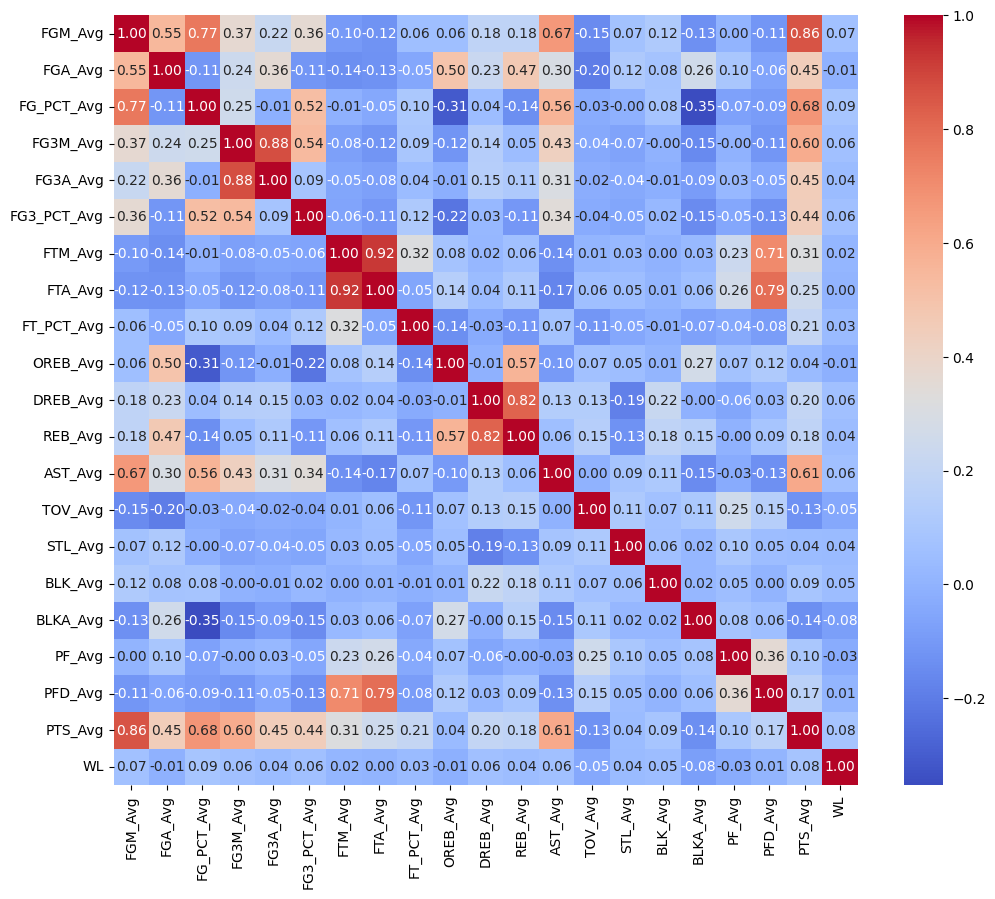

In [46]:
# plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [47]:
# silence setting with copy warning
pd.options.mode.chained_assignment = None


In [54]:

# Define columns containing rolling averages
cols = [f"{col}_Avg" for col in statistics_columns]

# Define column names for opponent statistics
cols_opponent = [f"{col}_Opp_Avg" for col in statistics_columns]

# Create an empty dataframe to store results
rolling_averages_with_opponent = pd.DataFrame()

# Group the dataframe by game ID
# It is enough to only groupby by the game id, as it is unique for each game even over multiple seasons
grouped = game_logs.groupby('GAME_ID')

# Iterate over each game
for game_id, game_data in grouped:
    # Separate home and away team data
    home_team_id = game_data[game_data['MATCHUP'].str.contains(' vs. ')]["TEAM_ID"].values[0]
    away_team_id = game_data[~game_data['MATCHUP'].str.contains(' vs. ')]["TEAM_ID"].values[0]

    home_team_data = rolling_averages_by_team.loc[(rolling_averages_by_team['TEAM_ID'] == home_team_id)
                                              & (rolling_averages_by_team['GAME_ID'] == game_id)]
    away_team_data = rolling_averages_by_team.loc[(rolling_averages_by_team['TEAM_ID'] == away_team_id)
                                                & (rolling_averages_by_team['GAME_ID'] == game_id)]
    
    # Add away_team_data[cols] to home_team_data as cols_opponent
    home_team_data[cols_opponent] = away_team_data[cols].values
    # Add home_team_data[cols] to away_team_data as cols_opponent
    away_team_data[cols_opponent] = home_team_data[cols].values
    # Append results to rolling_averages_with_opponent dataframe
    rolling_averages_with_opponent = pd.concat([rolling_averages_with_opponent, home_team_data])
    rolling_averages_with_opponent = pd.concat([rolling_averages_with_opponent, away_team_data])
    
# Now rolling_averages_by_team dataframe contains rolling averages for specified statistics for all team IDs
rolling_averages_with_opponent = rolling_averages_with_opponent.sort_values(by=['GAME_ID','MATCHUP'], ascending=True)
rolling_averages_with_opponent = rolling_averages_with_opponent.reset_index(drop=True)
rolling_averages_with_opponent.head()


,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg,FGM_Opp_Avg,FGA_Opp_Avg,FG_PCT_Opp_Avg,FG3M_Opp_Avg,FG3A_Opp_Avg,FG3_PCT_Opp_Avg,FTM_Opp_Avg,FTA_Opp_Avg,FT_PCT_Opp_Avg,OREB_Opp_Avg,DREB_Opp_Avg,REB_Opp_Avg,AST_Opp_Avg,TOV_Opp_Avg,STL_Opp_Avg,BLK_Opp_Avg,BLKA_Opp_Avg,PF_Opp_Avg,PFD_Opp_Avg,PTS_Opp_Avg
0,2015-16,1610612737,ATL,Atlanta Hawks,0021500001,2015-10-27T00:00:00,ATL vs. DET,0,48.0,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,15.0,9,4,3,25,15,94,-12.0,1,1231,1231,1231,155,1351,1498,1233,1141,728,1746,1975,2095,872,1867,1194,1699,1175,1303,671,1269,411,2059,2141,1851,1970,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-16,1610612765,DET,Detroit Pistons,0021500001,2015-10-27T00:00:00,DET @ ATL,1,48.0,37,96,0.385,12,29,0.414,20,26,0.769,23,36,59,23,15.0,5,3,4,15,25,106,12.0,1,1,1,1,155,1351,124,2199,305,505,641,737,762,1174,4,678,23,952,1303,1890,1713,749,216,289,899,434,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-16,1610612741,CHI,Chicago Bulls,0021500002,2015-10-27T00:00:00,CHI vs. CLE,1,48.0,37,87,0.425,7,19,0.368,16,23,0.696,7,40,47,13,13.0,6,10,7,22,21,97,2.0,1,1,1,1,155,1351,808,1692,1415,1827,1012,1349,1156,1806,1867,219,693,2382,813,1605,69,1826,1560,902,1632,1138,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-16,1610612739,CLE,Cleveland Cavaliers,0021500002,2015-10-27T00:00:00,CLE @ CHI,0,48.0,38,94,0.404,9,29,0.310,10,17,0.588,11,39,50,26,11.0,5,7,10,21,22,95,-2.0,1,1231,1231,1231,155,1156,201,2003,861,505,1597,2197,1899,2308,900,303,358,471,419,1890,385,2332,1352,708,1768,1264,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-16,1610612744,GSW,Golden State Warriors,0021500003,2015-10-27T00:00:00,GSW vs. NOP,1,48.0,41,96,0.427,9,30,0.300,20,22,0.909,21,35,56,29,20.0,8,7,3,29,26,111,16.0,1,1,1,1,155,612,124,1664,861,409,1692,737,1281,149,16,844,68,194,2198,953,385,411,2359,204,556,261,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
rolling_averages_with_opponent[rolling_averages_with_opponent['TEAM_ID'] == 1610612737].head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg,FGM_Opp_Avg,FGA_Opp_Avg,FG_PCT_Opp_Avg,FG3M_Opp_Avg,FG3A_Opp_Avg,FG3_PCT_Opp_Avg,FTM_Opp_Avg,FTA_Opp_Avg,FT_PCT_Opp_Avg,OREB_Opp_Avg,DREB_Opp_Avg,REB_Opp_Avg,AST_Opp_Avg,TOV_Opp_Avg,STL_Opp_Avg,BLK_Opp_Avg,BLKA_Opp_Avg,PF_Opp_Avg,PFD_Opp_Avg,PTS_Opp_Avg
0,2015-16,1610612737,ATL,Atlanta Hawks,0021500001,2015-10-27T00:00:00,ATL vs. DET,0,48.0,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,15.0,9,4,3,25,15,94,-12.0,1,1231,1231,1231,155,1351,1498,1233,1141,728,1746,1975,2095,872,1867,1194,1699,1175,1303,671,1269,411,2059,2141,1851,1970,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2015-16,1610612737,ATL,Atlanta Hawks,0021500019,2015-10-29T00:00:00,ATL @ NYK,1,48.0,42,83,0.506,10,24,0.417,18,26,0.692,7,32,39,26,16.0,11,4,4,18,24,112,11.0,1,1,1,1,155,477,1355,410,634,1124,610,1016,762,1829,1867,1370,1839,471,1535,279,1269,749,664,403,491,492,1.0,37.000000,82.000000,0.451000,8.000000,27.000000,0.296000,12.000000,15.00,0.8000,7.000000,33.00,40.000000,22.000000,15.000000,9.000000,4.0,3.000000,25.0,15.000000,94.00,42.0,93.000000,0.452,9.0,23.0,0.391000,29.000000,35.000000,0.829000,19.000000,30.0,49.000000,24.000000,11.000000,11.0,7.000000,4.000000,28.000000,27.000000,122.000000
50,2015-16,1610612737,ATL,Atlanta Hawks,0021500026,2015-10-30T00:00:00,ATL vs. CHA,1,48.0,36,83,0.434,8,23,0.348,17,22,0.773,8,37,45,23,15.0,9,4,6,17,20,97,3.0,1,1,1,1,155,1573,1355,1555,1141,1276,1231,1183,1281,1147,1618,531,970,952,1303,671,1269,1520,482,1110,1632,1053,1.0,39.500000,82.500000,0.478500,9.000000,25.500000,0.356500,15.000000,20.50,0.7460,7.000000,32.50,39.500000,24.000000,15.500000,10.000000,4.0,3.500000,21.5,19.500000,103.00,33.0,84.000000,0.393,6.0,24.0,0.250000,22.000000,29.000000,0.759000,11.000000,32.0,43.000000,16.000000,9.000000,4.0,1.000000,7.000000,16.000000,25.000000,94.000000
76,2015-16,1610612737,ATL,Atlanta Hawks,0021500039,2015-11-01T00:00:00,ATL @ CHA,1,48.0,37,88,0.420,7,29,0.241,13,14,0.929,9,39,48,22,11.0,9,6,13,16,14,94,2.0,1,1,1,1,155,1351,687,1764,1415,505,2112,1842,2186,105,1379,303,575,1175,419,671,636,2439,321,2246,1851,1138,1.0,38.333333,82.666667,0.463667,8.666667,24.666667,0.353667,15.666667,21.00,0.7550,7.333333,34.00,41.333333,23.666667,15.333333,9.666667,4.0,4.333333,20.0,19.666667,101.00,34.5,86.000000,0.401,9.0,27.0,0.325000,16.000000,21.000000,0.764000,12.000000,36.5,48.500000,19.500000,14.500000,5.5,3.500000,5.500000,18.000000,21.000000,94.000000
108,2015-16,1610612737,ATL,Atlanta Hawks,0021500055,2015-11-03T00:00:00,ATL @ MIA,1,48.0,37,90,0.411,7,21,0.333,17,22,0.773,16,35,51,25,16.0,10,1,9,14,21,98,6.0,1,1,1,1,155,1351,461,1900,1415,1553,1305,1183,1281,1147,170,844,278,617,1535,448,2293,2231,128,902,1547,808,1.0,38.000000,84.000000,0.452750,8.250000,25.750000,0.325500,15.000000,19.25,0.7985,7.750000,35.25,43.000000,23.250000,14.250000,9.500000,4.5,6.500000,19.0,18.250000,99.25,37.0,78.666667,0.470,9.0,21.0,0.431667,18.666667,21.333333,0.874333,6.333333,36.0,42.333333,22.666667,13.666667,7.0,6.333333,2.666667,20.333333,19.333333,101.666667


In [56]:
rolling_averages_with_opponent = rolling_averages_with_opponent.drop_duplicates(subset=['GAME_ID'], keep='first')
rolling_averages_with_opponent = rolling_averages_with_opponent.reset_index(drop=True)
rolling_averages_with_opponent.head()

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg,FGM_Opp_Avg,FGA_Opp_Avg,FG_PCT_Opp_Avg,FG3M_Opp_Avg,FG3A_Opp_Avg,FG3_PCT_Opp_Avg,FTM_Opp_Avg,FTA_Opp_Avg,FT_PCT_Opp_Avg,OREB_Opp_Avg,DREB_Opp_Avg,REB_Opp_Avg,AST_Opp_Avg,TOV_Opp_Avg,STL_Opp_Avg,BLK_Opp_Avg,BLKA_Opp_Avg,PF_Opp_Avg,PFD_Opp_Avg,PTS_Opp_Avg
0,2015-16,1610612737,ATL,Atlanta Hawks,0021500001,2015-10-27T00:00:00,ATL vs. DET,0,48.0,37,82,0.451,8,27,0.296,12,15,0.800,7,33,40,22,15.0,9,4,3,25,15,94,-12.0,1,1231,1231,1231,155,1351,1498,1233,1141,728,1746,1975,2095,872,1867,1194,1699,1175,1303,671,1269,411,2059,2141,1851,1970,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-16,1610612741,CHI,Chicago Bulls,0021500002,2015-10-27T00:00:00,CHI vs. CLE,1,48.0,37,87,0.425,7,19,0.368,16,23,0.696,7,40,47,13,13.0,6,10,7,22,21,97,2.0,1,1,1,1,155,1351,808,1692,1415,1827,1012,1349,1156,1806,1867,219,693,2382,813,1605,69,1826,1560,902,1632,1138,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-16,1610612744,GSW,Golden State Warriors,0021500003,2015-10-27T00:00:00,GSW vs. NOP,1,48.0,41,96,0.427,9,30,0.300,20,22,0.909,21,35,56,29,20.0,8,7,3,29,26,111,16.0,1,1,1,1,155,612,124,1664,861,409,1692,737,1281,149,16,844,68,194,2198,953,385,411,2359,204,556,261,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-16,1610612753,ORL,Orlando Magic,0021500004,2015-10-28T00:00:00,ORL vs. WAS,0,48.0,37,100,0.370,5,26,0.192,8,12,0.667,17,39,56,20,16.0,9,6,9,22,14,87,-1.0,1,1231,1231,1231,155,1351,41,2311,1983,850,2348,2345,2309,1962,109,303,68,1558,1535,671,636,2231,1560,2246,2225,1231,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-16,1610612738,BOS,Boston Celtics,0021500005,2015-10-28T00:00:00,BOS vs. PHI,1,48.0,39,85,0.459,8,24,0.333,26,27,0.963,10,31,41,31,17.0,10,7,6,23,22,112,17.0,1,1,1,1,155,957,1090,1106,1141,1124,1305,199,652,29,1134,1528,1556,103,1765,448,385,1520,1754,708,491,234,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
data_w_opp = rolling_averages_with_opponent[cols+cols_opponent+["WL"]].dropna().reset_index(drop=True)
data_w_opp.head()

,FGM_Avg,FGA_Avg,FG_PCT_Avg,FG3M_Avg,FG3A_Avg,FG3_PCT_Avg,FTM_Avg,FTA_Avg,FT_PCT_Avg,OREB_Avg,DREB_Avg,REB_Avg,AST_Avg,TOV_Avg,STL_Avg,BLK_Avg,BLKA_Avg,PF_Avg,PFD_Avg,PTS_Avg,FGM_Opp_Avg,FGA_Opp_Avg,FG_PCT_Opp_Avg,FG3M_Opp_Avg,FG3A_Opp_Avg,FG3_PCT_Opp_Avg,FTM_Opp_Avg,FTA_Opp_Avg,FT_PCT_Opp_Avg,OREB_Opp_Avg,DREB_Opp_Avg,REB_Opp_Avg,AST_Opp_Avg,TOV_Opp_Avg,STL_Opp_Avg,BLK_Opp_Avg,BLKA_Opp_Avg,PF_Opp_Avg,PFD_Opp_Avg,PTS_Opp_Avg,WL
0,32.0,86.0,0.372,9.0,23.0,0.391,26.0,31.0,0.8390,8.0,32.0,40.0,23.0,13.0,14.0,3.0,2.0,30.0,24.0,99.0,29.0,82.0,0.354,2.0,16.0,0.125,16.0,22.0,0.727,11.0,29.0,40.0,15.0,16.0,8.0,3.0,2.0,18.0,25.0,76.0,0
1,37.0,82.0,0.451,8.0,27.0,0.296,12.0,15.0,0.8000,7.0,33.0,40.0,22.0,15.0,9.0,4.0,3.0,25.0,15.0,94.0,42.0,93.0,0.452,9.0,23.0,0.391,29.0,35.0,0.829,19.0,30.0,49.0,24.0,11.0,11.0,7.0,4.0,28.0,27.0,122.0,1
2,40.0,85.0,0.471,10.0,21.0,0.476,21.0,31.0,0.6770,6.0,42.0,48.0,24.0,8.0,7.0,3.0,3.0,25.0,30.0,111.0,42.0,80.0,0.525,6.0,19.0,0.316,21.0,31.0,0.677,6.0,36.0,42.0,20.0,15.0,8.0,9.0,3.0,19.0,27.0,111.0,0
3,39.5,89.0,0.446,11.0,29.0,0.379,10.5,17.0,0.6175,11.5,40.5,52.0,27.5,15.0,6.0,4.5,6.5,23.0,20.0,100.5,36.0,73.0,0.493,12.0,20.0,0.600,20.0,21.0,0.952,2.0,39.0,41.0,23.0,13.0,5.0,7.0,1.0,25.0,16.0,104.0,1
4,42.0,86.0,0.488,7.0,19.0,0.368,21.0,22.0,0.9550,11.0,34.0,45.0,21.0,19.0,7.0,4.0,9.0,19.0,18.0,112.0,37.0,100.0,0.370,5.0,26.0,0.192,8.0,12.0,0.667,17.0,39.0,56.0,20.0,16.0,9.0,6.0,9.0,22.0,14.0,87.0,1


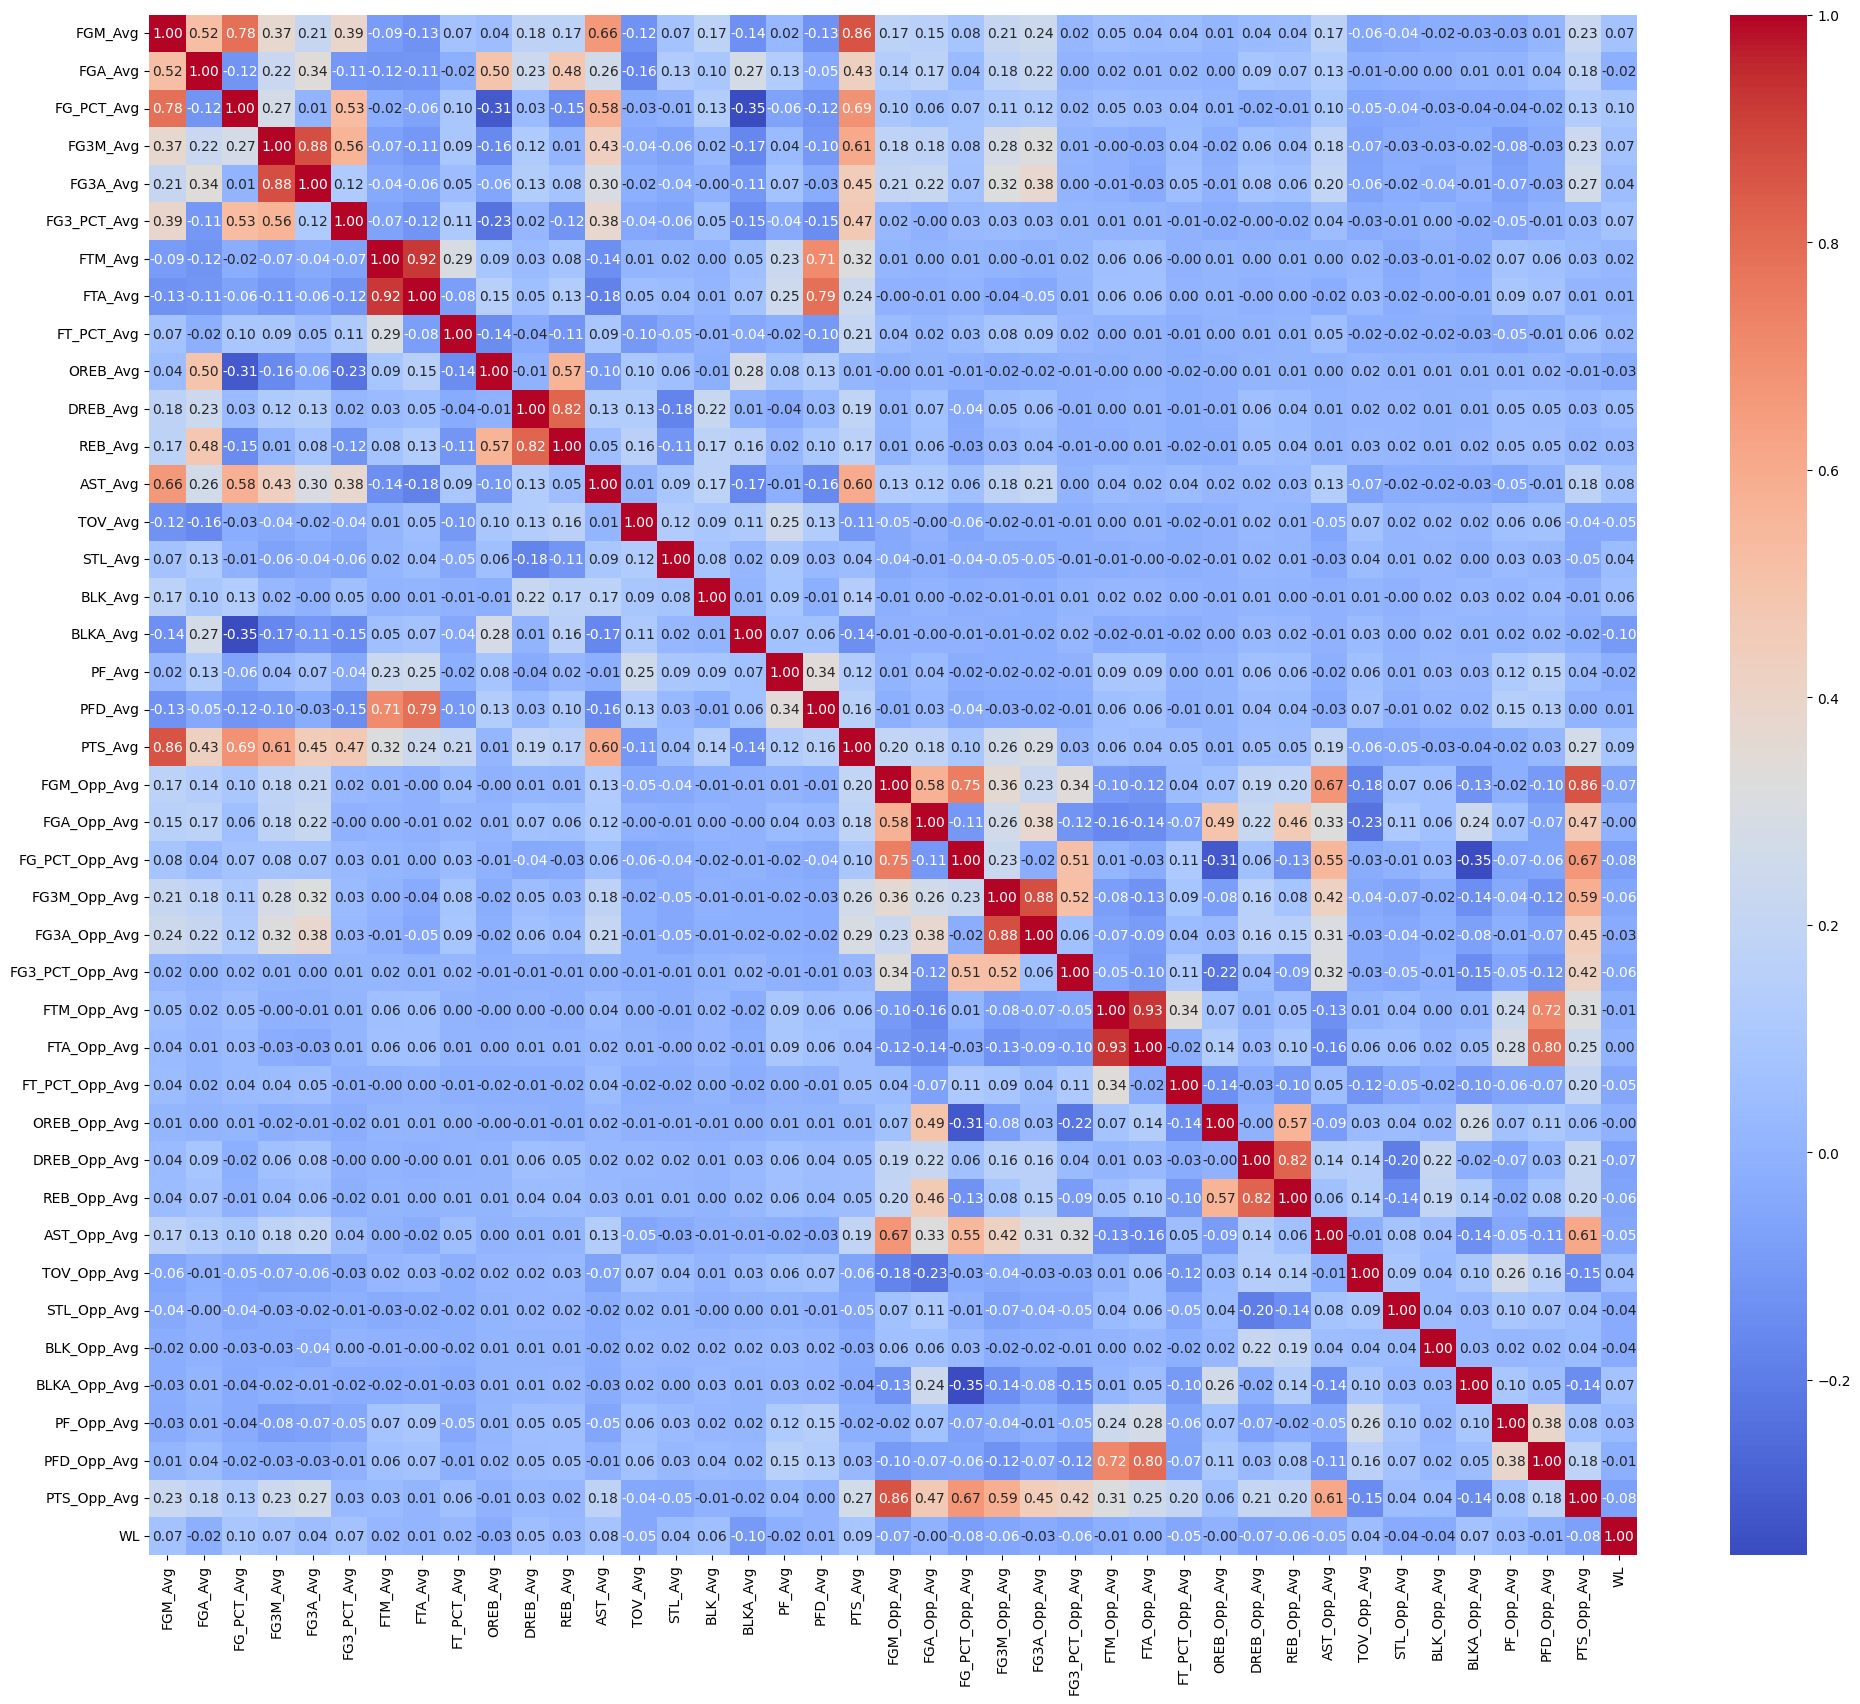

In [59]:
# plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = data_w_opp.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

              precision    recall  f1-score   support

           0       0.59      0.62      0.61       931
           1       0.61      0.58      0.59       947

    accuracy                           0.60      1878
   macro avg       0.60      0.60      0.60      1878
weighted avg       0.60      0.60      0.60      1878



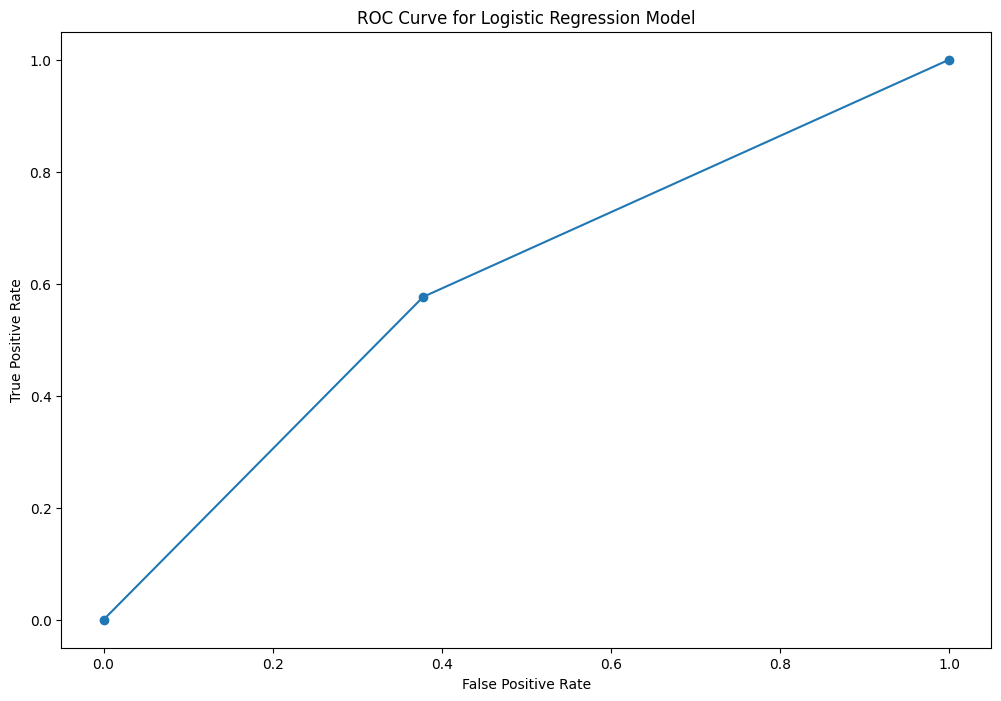

AUC: 0.5992347364110987


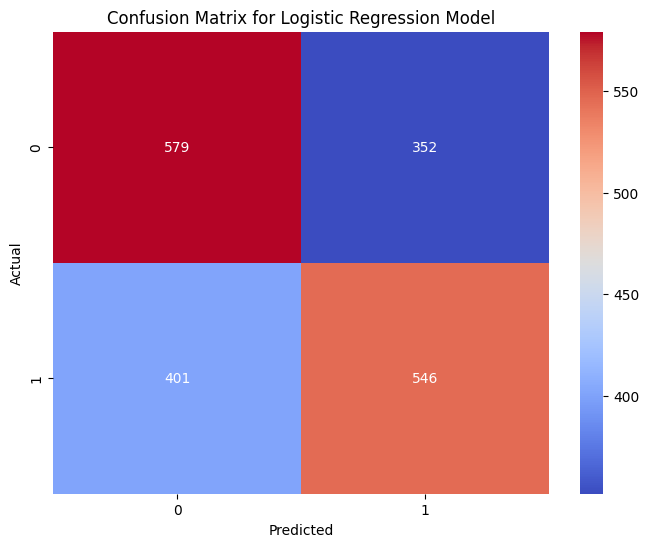

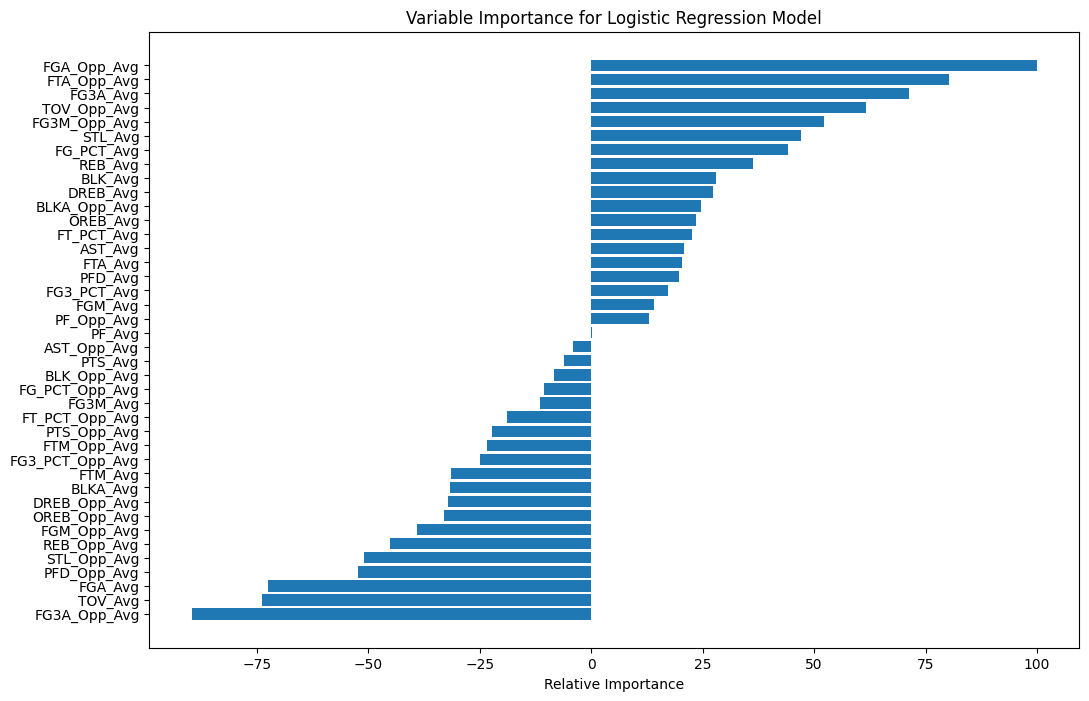

In [60]:
# make a regression model on PLUS_MINUS
# use the data_w_opp dataframe
# split the data into training and testing sets
# Scale the data
# Train the model
# Make predictions
# Calculate the precision, recall, and F1 score of the model
# Plot the ROC curve
# Calculate the AUC score
# Plot the confusion matrix
# Calculate the feature importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Define the target variable
target = 'WL'

# Define the features
features = cols + cols_opponent

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_w_opp[features], data_w_opp[target], test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate the precision, recall, and F1 score of the model
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.show()

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

# Calculate the feature importance
feature_importance = model.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Logistic Regression Model')
plt.show()




              precision    recall  f1-score   support

           0       0.57      0.62      0.59       931
           1       0.59      0.53      0.56       947

    accuracy                           0.58      1878
   macro avg       0.58      0.58      0.58      1878
weighted avg       0.58      0.58      0.58      1878



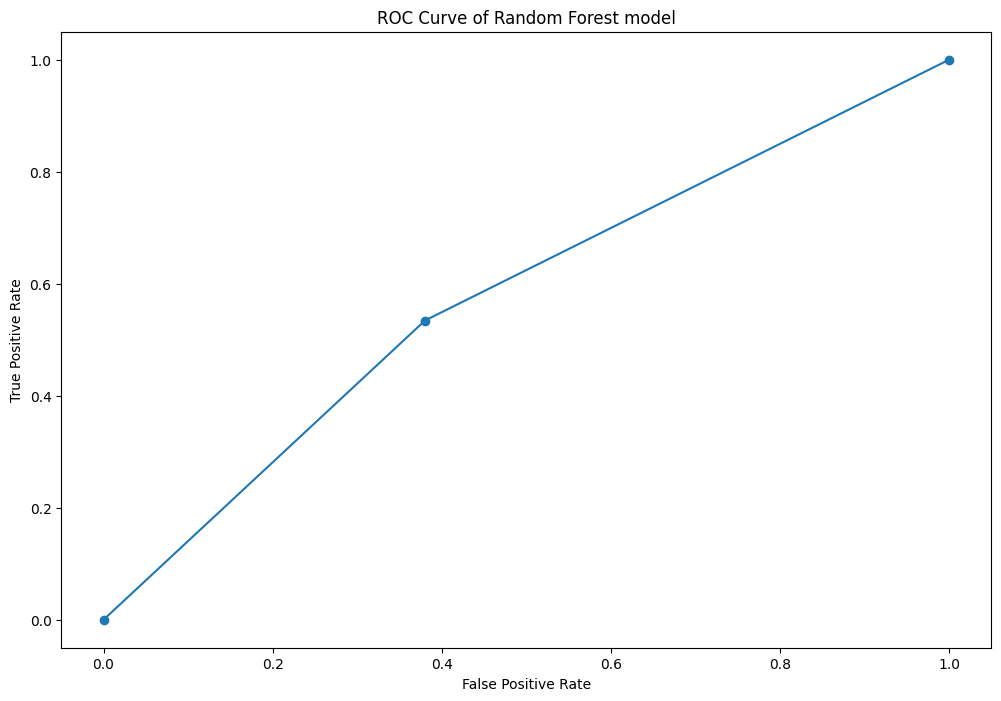

AUC: 0.5770412983734037


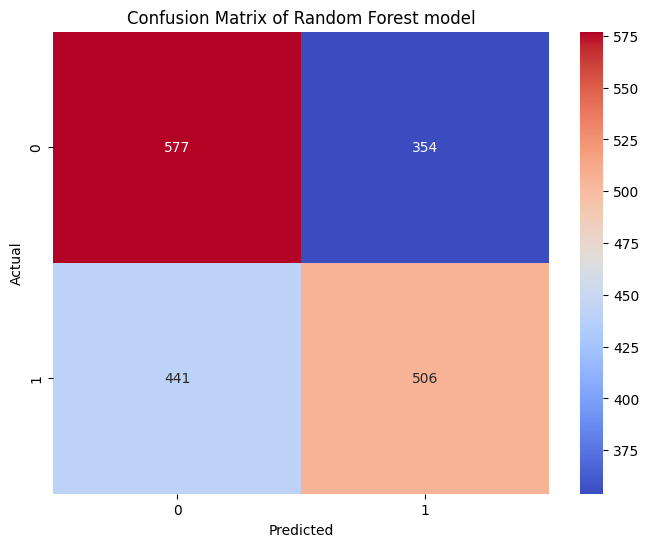

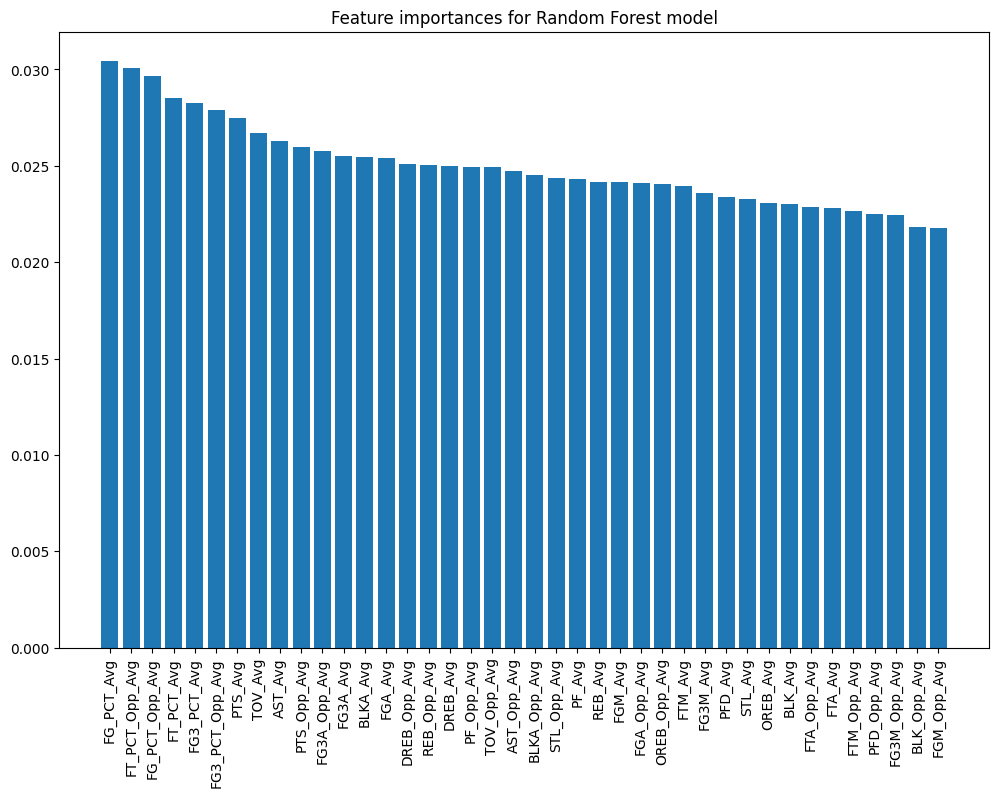

In [61]:
# Random Forest
# Train the model
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate the precision, recall, and F1 score of the model
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest model')
plt.show()

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Random Forest model')
plt.show()

# Calculate the feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.title("Feature importances for Random Forest model")
plt.show()